# HW4 - Question 2
## Part 2 - 1

In [30]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from textblob import Word
from sklearn.model_selection import train_test_split
import gensim.downloader as api
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, BatchNormalization, Dropout, Flatten, Activation
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv1D ,MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('/content/twitter-suicidal_data.csv')
df.reset_index(drop=True, inplace=True)
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


<Axes: title={'center': 'Classes Distribution'}>

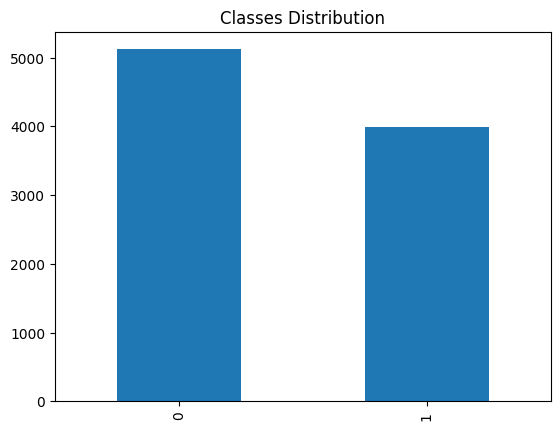

In [4]:
df['intention'].value_counts().plot(kind="bar",title='Classes Distribution')

In [5]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')

# remove duplicated words
df['notDuplicate_tweet'] = df['tweet'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))
# convert to all lower case
df['lower_case']= df['notDuplicate_tweet'].apply(lambda x: x.lower())
# tokenization, also remove colons and ...
tokenizer = RegexpTokenizer(r'\w+')
df['tokenized_tweet'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
# Remove stopwords
stop_words = stopwords.words('english')
df['stop_words'] = df['tokenized_tweet'].apply(lambda x: [word for word in x if word not in stop_words])
# replace unnecessary text (words less than 3 characters and not english words)
df['stop_words'] = df['stop_words'].astype('str')
df['short_word'] = df['stop_words'].str.findall('\w{3,}')
df['without_unnecessary'] = df['stop_words'].replace({"'": '', ',': ''}, regex=True)
df['without_unnecessary'] = df['without_unnecessary'].str.findall('\w{3,}').str.join(' ')
words = set(nltk.corpus.words.words())
df['english_tweet'] = df['without_unnecessary'].apply(lambda x: " ".join(x for x in x.split() if x in words))
# Lemmatization
df['clean_tweet'] = df['english_tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
df.head()

,tweet,intention,notDuplicate_tweet,lower_case,tokenized_tweet,stop_words,short_word,without_unnecessary,english_tweet,clean_tweet
0,my life is meaningless i just want to end my l...,1,my life is meaningless i just want to end so b...,my life is meaningless i just want to end so b...,"[my, life, is, meaningless, i, just, want, to,...","['life', 'meaningless', 'want', 'end', 'badly'...","[life, meaningless, want, end, badly, complete...",life meaningless want end badly completely emp...,life meaningless want end badly completely emp...,life meaningless want end badly completely emp...
1,muttering i wanna die to myself daily for a fe...,1,muttering i wanna die to myself daily for a fe...,muttering i wanna die to myself daily for a fe...,"[muttering, i, wanna, die, to, myself, daily, ...","['muttering', 'wanna', 'die', 'daily', 'months...","[muttering, wanna, die, daily, months, feel, w...",muttering wanna die daily months feel worthles...,muttering die daily feel worthless cant live h...,muttering die daily feel worthless cant live h...
2,work slave i really feel like my only purpose ...,1,work slave i really feel like my only purpose ...,work slave i really feel like my only purpose ...,"[work, slave, i, really, feel, like, my, only,...","['work', 'slave', 'really', 'feel', 'like', 'p...","[work, slave, really, feel, like, purpose, lif...",work slave really feel like purpose life make ...,work slave really feel like purpose life make ...,work slave really feel like purpose life make ...
3,i did something on the 2 of october i overdose...,1,i did something on the 2 of october overdosed ...,i did something on the 2 of october overdosed ...,"[i, did, something, on, the, 2, of, october, o...","['something', '2', 'october', 'overdosed', 'fe...","[something, october, overdosed, felt, alone, h...",something october overdosed felt alone horribl...,something felt alone horrible hospital two day...,something felt alone horrible hospital two day...
4,i feel like no one cares i just want to die ma...,1,i feel like no one cares just want to die mayb...,i feel like no one cares just want to die mayb...,"[i, feel, like, no, one, cares, just, want, to...","['feel', 'like', 'one', 'cares', 'want', 'die'...","[feel, like, one, cares, want, die, maybe, les...",feel like one cares want die maybe less lonely,feel like one want die maybe less lonely,feel like one want die maybe le lonely


In [7]:
# Create a DataFrame with a single row containing the sentence
sentence = "my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives"
data = {'tweet': [sentence]}
df_ex = pd.DataFrame(data)

# Preprocessing steps
df_ex['notDuplicate_tweet'] = df_ex['tweet'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))
df_ex['lower_case'] = df_ex['notDuplicate_tweet'].apply(lambda x: x.lower())
tokenizer = RegexpTokenizer(r'\w+')
df_ex['tokenized_tweet'] = df_ex.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
stop_words = set(stopwords.words('english'))
df_ex['stop_words'] = df_ex['tokenized_tweet'].apply(lambda x: [word for word in x if word not in stop_words])
df_ex['stop_words'] = df_ex['stop_words'].astype('str')
df_ex['short_word'] = df_ex['stop_words'].str.findall('\w{3,}')
df_ex['without_unnecessary'] = df_ex['stop_words'].replace({"'": '', ',': ''}, regex=True)
df_ex['without_unnecessary'] = df_ex['without_unnecessary'].str.findall('\w{3,}').str.join(' ')
english_words = set(nltk.corpus.words.words())
df_ex['english_tweet'] = df_ex['without_unnecessary'].apply(lambda x: " ".join(x for x in x.split() if x in english_words))
df_ex['clean_tweet'] = df_ex['english_tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Print the preprocessed sentence
preprocessed_sentence = df['clean_tweet'].values[0]
print(preprocessed_sentence)

life meaningless want end badly completely empty dont create meaning pain long hold back urge run car head first next person coming opposite way stop feeling jealous tragic like gomer pile swift able bring


## Part 2 - 2

In [8]:
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["clean_tweet"])
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df["clean_tweet"])
maxx = []
for i in range(len(sequences)):
    maxx.append(len(sequences[i]))
length_max = np.max(maxx)

embedding = np.zeros((len(word_index)+1, 300))
for word in word_index.keys():
    if word in word2vec.key_to_index:
        embedding[word_index[word], :] = np.array(word2vec.get_vector(word))
    else:
        embedding[word_index[word], :] = np.random.randn(300)

x_pad = pad_sequences(sequences,maxlen=length_max)

In [10]:
labels = to_categorical(df['intention'], num_classes=2)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_pad, labels, test_size = 0.1, random_state = 10)

In [12]:
embedding_layer = Embedding((len(word_index) + 1), 300, embeddings_initializer=Constant(embedding),
                    input_length=length_max, trainable = False)

## Part 2 - 3

In [13]:
epochs = 20
batch_size = 64

In [65]:
model0=Sequential()
model0.add(embedding_layer)
model0.add(Dropout(0.5))
model0.add(LSTM(300, dropout=0.5))
model0.add(Dense(2, activation='softmax'))
model0.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
print(model0.summary())
fit0 = model0.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 601, 300)          2770500   
                                                                 
 dropout_25 (Dropout)        (None, 601, 300)          0         
                                                                 
 lstm_47 (LSTM)              (None, 300)               721200    
                                                                 
 dense_25 (Dense)            (None, 2)                 602       
                                                                 
Total params: 3492302 (13.32 MB)
Trainable params: 721802 (2.75 MB)
Non-trainable params: 2770500 (10.57 MB)
_________________________________________________________________
None
Epoch 1/20
129/129 [==============================] - 47s 86ms/step - loss: 0.3543 - acc: 0.8427 - val_loss: 0.2819 - val_acc: 0.8882
Epo

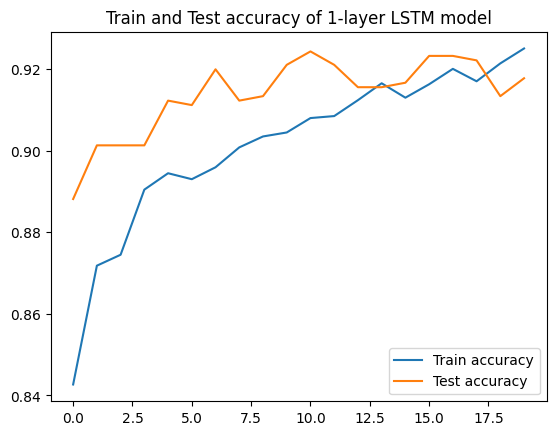

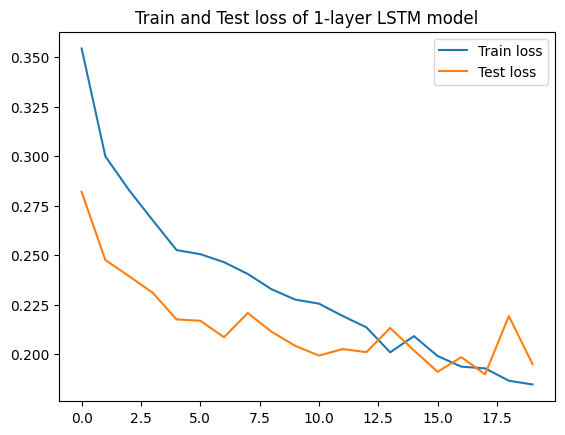

In [66]:
accuracy = fit0.history['acc']
val_acc = fit0.history['val_acc']
loss = fit0.history['loss']
val_loss = fit0.history['val_loss']

plt.plot(accuracy, label='Train accuracy')
plt.plot(val_acc, label='Test accuracy')
plt.title('Train and Test accuracy of 1-layer LSTM model')
plt.legend()
plt.figure()
plt.plot( loss, label='Train loss')
plt.plot( val_loss, label='Test loss')
plt.title('Train and Test loss of 1-layer LSTM model')
plt.legend()
plt.show()

In [67]:
y_pred0 = model0.predict(x_test)
y_pred0 = (y_pred0 > 0.5)

#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred0, target_names=['Suicide_Post', 'Not_Suicide_Post']))

29/29 [==============================] - 1s 21ms/step
                  precision    recall  f1-score   support

    Suicide_Post       0.91      0.95      0.93       521
Not_Suicide_Post       0.93      0.88      0.90       391

       micro avg       0.92      0.92      0.92       912
       macro avg       0.92      0.91      0.92       912
    weighted avg       0.92      0.92      0.92       912
     samples avg       0.92      0.92      0.92       912



In [62]:
model1=Sequential()
model1.add(embedding_layer)
model1.add(Dropout(0.5))
model1.add(LSTM(300, dropout=0.5, return_sequences=True))
model1.add(LSTM(300, dropout=0.5))
model1.add(Dense(2, activation='softmax'))
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
print(model1.summary())
fit1 = model1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 601, 300)          2770500   
                                                                 
 dropout_24 (Dropout)        (None, 601, 300)          0         
                                                                 
 lstm_45 (LSTM)              (None, 601, 300)          721200    
                                                                 
 lstm_46 (LSTM)              (None, 300)               721200    
                                                                 
 dense_24 (Dense)            (None, 2)                 602       
                                                                 
Total params: 4213502 (16.07 MB)
Trainable params: 1443002 (5.50 MB)
Non-trainable params: 2770500 (10.57 MB)
_________________________________________________________________
None
Epoc

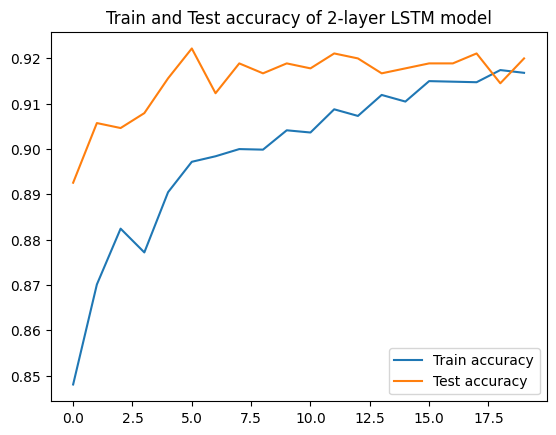

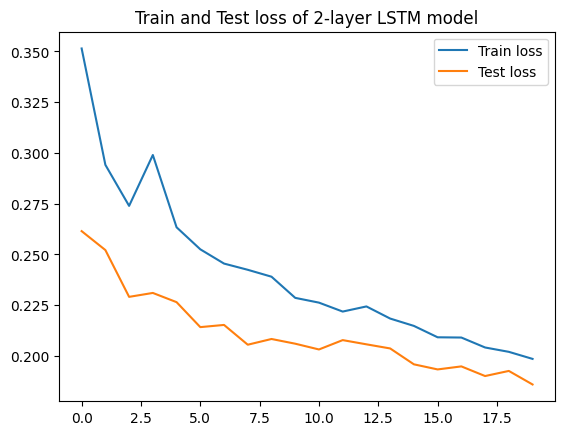

In [63]:
accuracy = fit1.history['acc']
val_acc = fit1.history['val_acc']
loss = fit1.history['loss']
val_loss = fit1.history['val_loss']

plt.plot(accuracy, label='Train accuracy')
plt.plot(val_acc, label='Test accuracy')
plt.title('Train and Test accuracy of 2-layer LSTM model')
plt.legend()
plt.figure()
plt.plot( loss, label='Train loss')
plt.plot( val_loss, label='Test loss')
plt.title('Train and Test loss of 2-layer LSTM model')
plt.legend()
plt.show()

In [68]:
y_pred1 = model1.predict(x_test)
y_pred1 = (y_pred1 > 0.5)

#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred1, target_names=['Suicide_Post', 'Not_Suicide_Post']))

29/29 [==============================] - 1s 36ms/step
                  precision    recall  f1-score   support

    Suicide_Post       0.91      0.96      0.93       521
Not_Suicide_Post       0.94      0.87      0.90       391

       micro avg       0.92      0.92      0.92       912
       macro avg       0.92      0.91      0.92       912
    weighted avg       0.92      0.92      0.92       912
     samples avg       0.92      0.92      0.92       912



In [53]:
model2=Sequential()
model2.add(embedding_layer)
model2.add(Conv1D(64, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size = 2))
model2.add(Dropout(0.5))
model2.add(LSTM(300, dropout=0.5, return_sequences=True))
model2.add(LSTM(300, dropout=0.5))
model2.add(Dense(2, activation='softmax'))
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())
fit2 = model2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 601, 300)          2770500   
                                                                 
 conv1d_17 (Conv1D)          (None, 601, 64)           57664     
                                                                 
 activation_17 (Activation)  (None, 601, 64)           0         
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 300, 64)           0         
 ng1D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 300, 64)           0         
                                                                 
 lstm_40 (LSTM)              (None, 300, 300)          438000    
                                                     

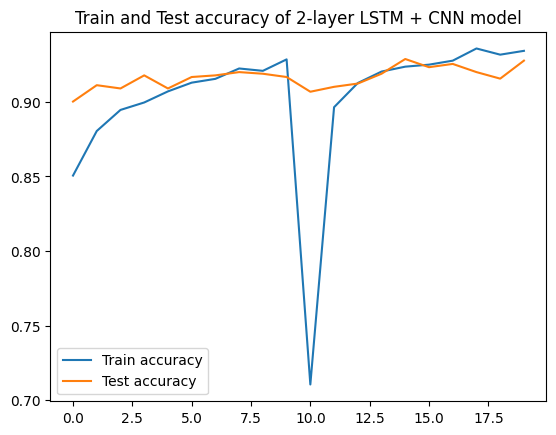

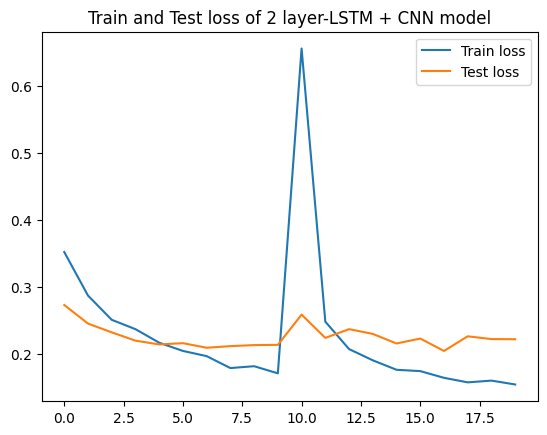

In [54]:
accuracy = fit2.history['acc']
val_acc = fit2.history['val_acc']
loss = fit2.history['loss']
val_loss = fit2.history['val_loss']

plt.plot(accuracy, label='Train accuracy')
plt.plot(val_acc, label='Test accuracy')
plt.title('Train and Test accuracy of 2-layer LSTM + CNN model')
plt.legend()
plt.figure()
plt.plot( loss, label='Train loss')
plt.plot( val_loss, label='Test loss')
plt.title('Train and Test loss of 2 layer-LSTM + CNN model')
plt.legend()
plt.show()

In [69]:
y_pred2 = model2.predict(x_test)
y_pred2 = (y_pred0 > 0.5)

#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred2, target_names=['Suicide_Post', 'Not_Suicide_Post']))

29/29 [==============================] - 1s 21ms/step
                  precision    recall  f1-score   support

    Suicide_Post       0.91      0.95      0.93       521
Not_Suicide_Post       0.93      0.88      0.90       391

       micro avg       0.92      0.92      0.92       912
       macro avg       0.92      0.91      0.92       912
    weighted avg       0.92      0.92      0.92       912
     samples avg       0.92      0.92      0.92       912

